# Check solve_kolmogorov

In [1]:
import numpy as np
import matplotlib.pylab as plt

import itertools
import pandas as pd

import sys
sys.path.append('../src/')
import solve_kolmogorov
import simulate_gillespie
import Hypergraphs

from scipy.integrate import solve_ivp

from scipy.special import comb

In [11]:
"""Complete case test."""
# setup
nsims = 10 # number of simulation runs
time_max = 10   # maximum time duration


N = 100
g = Hypergraphs.CompleteHypergraph(N)

I0 = 1 # number of initial infected
initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

Setup: 

	H = CompleteHypergraph, N = 100, I0 = 1

	beta1 = 0.02, beta2 = 0.0004, mu = 1



In [12]:
run_gillespie_simulations = False
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = simulate_gillespie.gillespie_sim(
            g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed('../results/sim_results.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load('../results/gillespie-sims_test_1.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

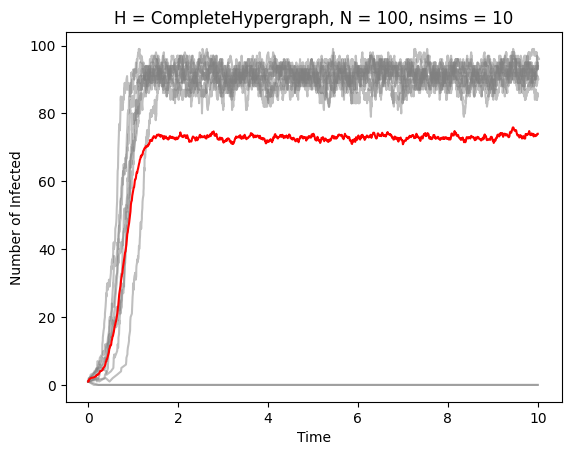

In [13]:
# plot X_t curves in gray and average curve in red
fig = plt.figure()
ax  = plt.subplot()
for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5)
avg_curve, times = simulate_gillespie.get_average(X_sims, time_max, nsims, delta_t = 0.01)
plt.plot(times, avg_curve, "red")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# plt.savefig("../figures/solutions-kolmogorov/complete/gillespie-sims.pdf", 
#             format='pdf', bbox_inches='tight')
plt.show()

In [40]:
# solve KEs and compare
all_states = solve_kolmogorov.list_all_states(g)
M = len(all_states)
ode_system_complete = solve_kolmogorov.list_all_ODEs_complete(g, beta1, beta2, mu)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(1)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

# solve ode_system_complete over time
# e.g. from 0 to 10
t_span = (0.0, 10.0)

# times t_i to evaluate in, get saved in sol.t
t_eval = np.linspace(t_span[0], t_span[1], 101)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="RK45"
)

In [41]:
p_vals = sol.y # matrix of shape (M x ntimes)
M, ntimes = p_vals.shape # M = N + 1 for complete case

In [42]:
np.sum(p_vals[:, ntimes - 1])

np.float64(0.999999999999991)

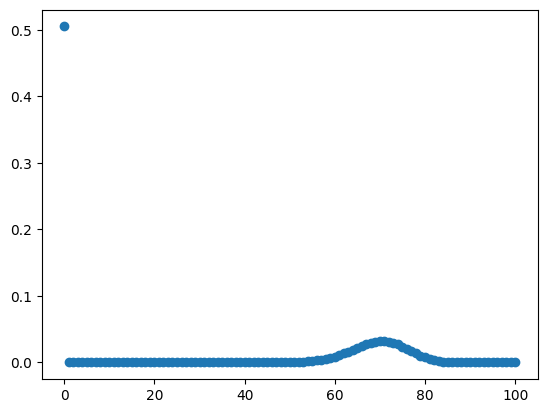

In [43]:
plt.figure()
plt.scatter([k for k in range(N + 1)], p_vals[:, ntimes - 1])

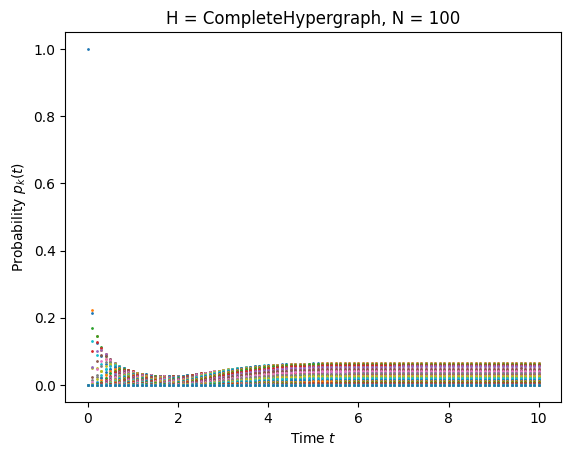

In [39]:
# plot the results: probability of each state over time
plt.figure()
for k in all_states:
    # plt.scatter(sol.t, sol.y[k], s = 1, label=str(k))
    plt.scatter(sol.t, sol.y[k], s = 1)
plt.xlabel(r"Time $t$")
plt.ylabel(r"Probability $p_{k}(t)$")
# plt.legend()
plt.title(f"H = {g.__class__.__name__}, N = {N}")
# plt.savefig("../figures/solutions-kolmogorov/complete/probabilities.pdf", 
#         format='pdf', bbox_inches='tight')
plt.show()

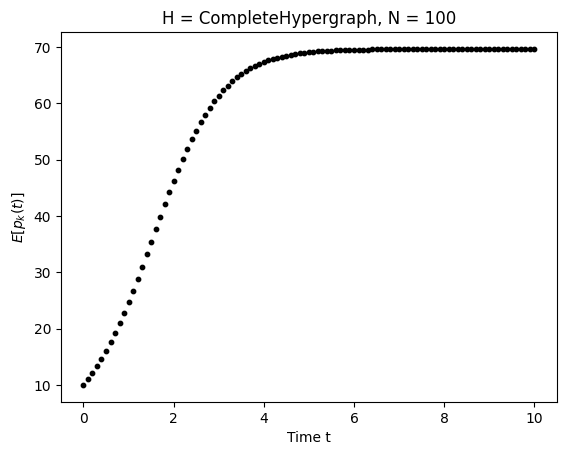

In [9]:
# plot the expected values of p_{k}(t) over time t
expected_values = solve_kolmogorov.calculate_expected_values(sol)
plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.xlabel("Time t")
plt.ylabel(r"$E[p_{k}(t)]$")
# plt.legend()
plt.title(f"H = {g.__class__.__name__}, N = {N}")
# plt.savefig("../figures/solutions-kolmogorov/complete/expected-values.pdf", 
#             format='pdf', bbox_inches='tight')       
plt.show()

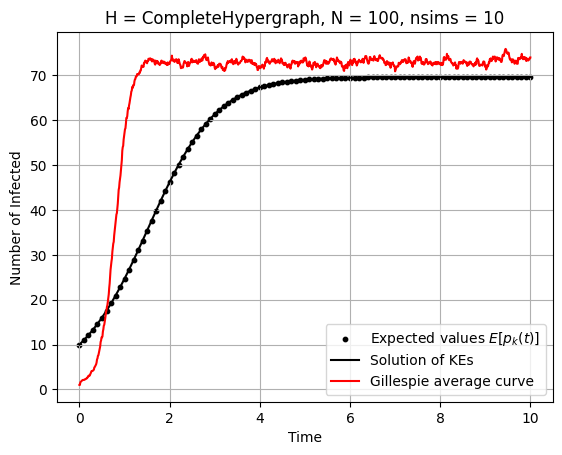

In [10]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure
plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, color="k",
            label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# plt.savefig("../figures/solutions-kolmogorov/complete/solution-vs-gillespie-avg.pdf", 
#             format='pdf', bbox_inches='tight') 
plt.show()